In [429]:
import numpy as np
import numpy.random as rand
import math
import time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize

# Linear and rational functions and  numerical minimization functions for the method of least squares

In [520]:
def lin(x,a,b):
    return a*x + b

def rat(x,a,b):
    return a/(b*x + 1)
    
def funcmls_lin(koord,x,y):
    return sum((koord[0]*x+koord[1]-y)**2)

def grad_lin(koord,x,y):
    grad = np.array([0.0,0.0])
    grad[0] = np.sum(2*x*(koord[0]*x+koord[1]-y))
    grad[1] = np.sum(2*(koord[0]*x+koord[1]-y))
    return grad

def hessian_lin(x,y,koord):
    hessian = np.zeros((2,2),dtype=float)
    hessian[0][0]=sum(2*x**2)
    hessian[0][1]=hessian[1][0]=sum(2*x)
    hessian[1][1]=2
    return hessian

def funcmls_rat(koord,x,y):
    return sum(((koord[0]/(1+x*koord[1]))-y)**2)

def grad_rat(koord,x,y):
    grad = np.array([0.0,0.0])
    grad[0] = np.sum(2*(1/(1+koord[1]*x))*((koord[0]/(1+x*koord[1]))-y))
    grad[1] = np.sum(2*(-koord[0]*x/(1+koord[1]*x)**2)*((koord[0]/(1+x*koord[1]))-y))
    return grad

def hessian_rat(x,y,koord):
    hessian = np.zeros((2,2),dtype=float)
    hessian[0][0]=sum(2/((1+koord[1]*x)**2))
    hessian[0][1]=hessian[1][0]=sum((2*x*y/(1+koord[1]*x)**2)-(4*x*koord[0]/(1+koord[1]*x)**3))
    hessian[1][1]=sum(((6*(x**2)*(koord[0]**2))/(1+koord[1]*x)**4)-(4*(x**2)*y*koord[0]/(1+koord[1]*x)**3))
   
    return hessian

# Gradient Descent, Conjugate Gradient Descent, Newton’s method and Levenberg-Marquardt algorithm

In [450]:
def Gradient_Descent(grad, a0, b0, eps, x, y):
    koord0 = np.array([a0,b0])
    koord1 = koord0-np.random.randn(1)*grad(koord0,x,y)

    yiter = 0
    xiter = 0
    
    while (np.linalg.norm(koord1-koord0) > eps):
        beta_num = np.abs(np.matmul((koord1-koord0),(grad(koord1,x,y)-grad(koord0,x,y))))
        beta_den = np.linalg.norm(grad(koord1,x,y)-grad(koord0,x,y))**2
        beta = beta_num/beta_den
        xiter+=1
        yiter+=2
        koord0 = koord1
        koord1 = koord0-beta*grad(koord0,x,y)
    return (koord1[0], koord1[1], yiter, xiter)

def Conjugate_Gradient_Descent(funcmls, grad, a0, b0, eps, x, y):
    koord0 = np.array([a0,b0])
    f = lambda a: funcmls(koord0-a*grad(koord0,x,y),x,y)
    alfa0 = minimize(f,1,method='Nelder-Mead').x
    koord1 = koord0-alfa0*grad(koord0,x,y)
    s0 = -grad(koord0,x,y)

    yiter = 2
    xiter = 0

    while (np.linalg.norm(koord1-koord0) > eps):
        g1 = grad(koord1,x,y)
        g0 = grad(koord0,x,y)

        beta_num = np.matmul(g1,g1)
        beta_den = np.matmul(g0,g0)
        beta = beta_num/beta_den

        s1 = -g1+beta*s0

        f = lambda a: funcmls(koord1-a*grad(koord1,x,y),x,y)
        alfa1 = minimize(f,1,method='Nelder-Mead').x

        koord0 = koord1
        koord1 = koord0+alfa1*s1
        s0=s1
        xiter += 1
        yiter += 2
    return (koord1[0], koord1[1], yiter, xiter)

def Newton(funcmls, grad, hessian, a0, b0, eps, x, y):
    xiter = 0
    yiter = 2
    koord0 = np.array([a0,b0])
    koord1 = koord0-np.matmul(np.linalg.inv(hessian(x,y,koord0)),grad(koord0,x,y))

    while (np.linalg.norm(koord1-koord0) > eps):
        koord0=koord1
        
        f = lambda a: funcmls(koord0-a*np.matmul(np.linalg.inv(hessian(x,y,koord0)),grad(koord0,x,y)),x,y)
        alfa = minimize(f,1,method='Nelder-Mead').x

        koord1 = koord0-alfa*np.matmul(np.linalg.inv(hessian(x,y,koord0)),grad(koord0,x,y))
        xiter += 1
        yiter += 2

    return (koord1[0], koord1[1], yiter, xiter)

# Generate data

In [432]:
from random import random
from random import normalvariate
alfa = random()
betta = random()
k = np.arange (101)
x = k/100
y = np.array(k,dtype='float32')

for k in range(101): 
    delta = normalvariate(0, 1)
    y[k] = alfa*x[k]+betta+delta

print (alfa, betta)

0.30410194380705613 0.39718953205822816


In [521]:
popt, _ = curve_fit(rat, x, y)
a_sum, b_sum = popt

print (a_sum, b_sum)

a_grad, b_grad, yiter_grad, xiter_grad = Gradient_Descent(grad_rat, 0.1, 0.1, 0.001, x, y)
print (a_grad, b_grad, yiter_grad, xiter_grad)

a1,b1, yiter1, xiter1 = Conjugate_Gradient_Descent(funcmls_rat, grad_rat, 0.5, -0.5, 0.001, x, y)
print(a1,b1, yiter1, xiter1)

a2,b2, yiter2, xiter2 = Newton(funcmls_rat, grad_rat, hessian_rat, 0.5, -0.5, 0.01, x, y)
print(a2,b2, yiter2, xiter2)

0.42499568256968767 -0.470200169619141
0.0159410312423245 -3.7470538679045133 66 33
0.42784517089214485 -0.4629372085439049 4 1
0.4248672747348394 -0.4704529943358103 6 2


In [525]:
popt, _ = curve_fit(lin, x, y, method = 'lm',maxfev=5)
a_sum, b_sum = popt
print (a_sum, b_sum)

popt, _ = curve_fit(rat, x, y, method = 'lm',maxfev=23)
a_sum, b_sum = popt
print (a_sum, b_sum)

0.21836244026734963 0.4691078474395135
0.42499568256968767 -0.470200169619141


In [470]:
!pip install prettytable

  Using cached prettytable-2.2.1-py3-none-any.whl (23 kB)


# Calculation results

In [522]:
alfa_lin_1,betta_lin_1,countf_lin_1,iter_lin_1 = Gradient_Descent(grad_lin, 0, 0, 0.001, x, y)
res_lin_1 = (funcmls_lin([alfa_lin_1,betta_lin_1],x,y))
alfa_lin_2,betta_lin_2,countf_lin_2,iter_lin_2 = Conjugate_Gradient_Descent(funcmls_lin, grad_lin, 0, 0, 0.001, x, y)
res_lin_2 = (funcmls_lin([alfa_lin_2,betta_lin_2],x,y))
alfa_lin_3,betta_lin_3,countf_lin_3,iter_lin_3 = Newton(funcmls_lin, grad_lin, hessian_lin, 0, 0, 0.01, x, y)
res_lin_3 = (funcmls_lin([alfa_lin_3,betta_lin_3],x,y))

popt, _ = curve_fit(lin, x, y, method = 'lm')
alfa_lin_4,betta_lin_4 = popt
res_lin_4 = (funcmls_lin([alfa_lin_4,betta_lin_4],x,y))

alfa_rat_1,betta_rat_1,countf_rat_1,iter_rat_1 = Gradient_Descent(grad_rat, 0.5, -0.5, 0.001, x, y)
res_rat_1 = (funcmls_rat([alfa_rat_1,betta_rat_1],x,y))
alfa_rat_2,betta_rat_2,countf_rat_2,iter_rat_2 = Conjugate_Gradient_Descent(funcmls_rat, grad_rat, 0.5, -0.5, 0.001, x, y)
res_rat_2 = (funcmls_rat([alfa_rat_2,betta_rat_2],x,y))
alfa_rat_3,betta_rat_3,countf_rat_3,iter_rat_3 = Newton(funcmls_lin, grad_lin, hessian_lin, 0, 0, 0.01, x, y)
res_rat_3 = (funcmls_rat([alfa_rat_3,betta_rat_3],x,y))

popt, _ = curve_fit(rat, x, y, method = 'lm')
alfa_rat_4,betta_rat_4 = popt
res_rat_4 = (funcmls_rat([alfa_rat_4,betta_rat_4],x,y))

from prettytable import PrettyTable
th = ['Function', 'Method', 'a', 'b', 'minimum f', ' number of f-calculations', 'number of iterations' ]
td = ['ax+b', 'Gradient Descent', '%.3f' % alfa_lin_1, '%.3f' % betta_lin_1, '%.3f' % res_lin_1, countf_lin_1, iter_lin_1,
      'ax+b', 'Conjugate Gradient Descent', '%.3f' % alfa_lin_2, '%.3f' % betta_lin_2, '%.3f' % res_lin_2, countf_lin_2, iter_lin_2,
      'ax+b', 'Newton’s method', '%.3f' % alfa_lin_3, '%.3f' % betta_lin_3, '%.3f' % res_lin_3, countf_lin_3, iter_lin_3,
      'ax+b', 'Levenberg-Marquardt algorithm', '%.3f' % alfa_lin_4, '%.3f' % betta_lin_4, '%.3f' % res_lin_4, 7, 5,
      '', '', '', '', '', '', '',
      'a/(1+bx)', 'Gradient Descent', '%.3f' % alfa_rat_1, '%.3f' % betta_rat_1, '%.3f' % res_rat_1, countf_rat_1, iter_rat_1,
      'a/(1+bx)', 'Conjugate Gradient Descent', '%.3f' % alfa_rat_2, '%.3f' % betta_rat_2, '%.3f' % res_rat_2, countf_rat_2, iter_rat_2,
      'a/(1+bx)', 'Newton’s method', '%.3f' % alfa_rat_3, '%.3f' % betta_rat_3, '%.3f' % res_rat_3, countf_rat_3, iter_rat_3,
      'a/(1+bx)', 'Levenberg-Marquardt algorithm', '%.3f' % alfa_rat_4, '%.3f' % betta_rat_4, '%.3f' % res_rat_4, 25, 23]

columns = len(th)
table = PrettyTable(th)
td_data = td[:]

while td_data:
    table.add_row(td_data[:columns])
    td_data = td_data[columns:]

print(table) 

+----------+-------------------------------+-------+--------+-----------+---------------------------+----------------------+
| Function |             Method            |   a   |   b    | minimum f |  number of f-calculations | number of iterations |
+----------+-------------------------------+-------+--------+-----------+---------------------------+----------------------+
|   ax+b   |        Gradient Descent       | 0.218 | 0.470  |   98.193  |             4             |          2           |
|   ax+b   |   Conjugate Gradient Descent  | 0.220 | 0.468  |   98.193  |             10            |          4           |
|   ax+b   |        Newton’s method        | 0.218 | 0.469  |   98.193  |             6             |          2           |
|   ax+b   | Levenberg-Marquardt algorithm | 0.218 | 0.469  |   98.193  |             7             |          5           |
|          |                               |       |        |           |                           |                      |


# Results graphs

<ipython-input-523-acc4e5f8ebe7>:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname = "D:/Магистр/Algorithms/graph_1lab_task3_lin.png", dpi=300, facecolor='w', edgecolor='w',
<ipython-input-523-acc4e5f8ebe7>:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname = "D:/Магистр/Algorithms/graph_1lab_task3_lin.png", dpi=300, facecolor='w', edgecolor='w',
<ipython-input-523-acc4e5f8ebe7>:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fname = "D:/Магистр/Algorithms/graph_2lab_task3_rat.png", dpi=300, facecolor='w', edgecolor='w',
<ipython-input-523-acc4e5f8ebe7>:28: Ma

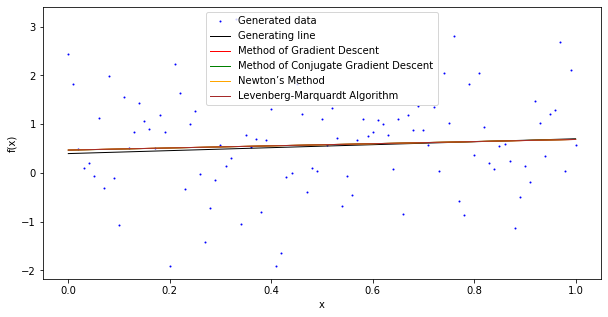

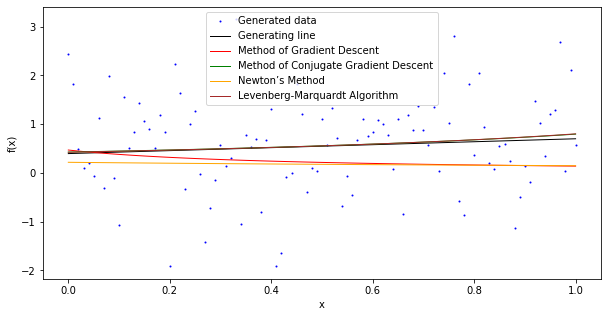

In [523]:
plt.figure(figsize=(10,5))
plt.plot(x, y, 'bo', label='Generated data', markersize=1)
plt.plot(x, funclin(alfa,betta,x),'', color = 'black', linewidth=1, label="Generating line")
plt.plot(x, funclin(alfa_lin_1,betta_lin_1,x),'', color = 'red', linewidth=1, label="Method of Gradient Descent")
plt.plot(x, funclin(alfa_lin_2,betta_lin_2,x),'', color = 'green', linewidth=1, label="Method of Conjugate Gradient Descent")
plt.plot(x, funclin(alfa_lin_3,betta_lin_3,x),'', color = 'orange', linewidth=1, label="Newton’s Method")
plt.plot(x, funclin(alfa_lin_4,betta_lin_4,x),'', color = 'brown', linewidth=1, label="Levenberg-Marquardt Algorithm")

plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.savefig(fname = "D:/Магистр/Algorithms/graph_1lab_task3_lin.png", dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None, 
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

plt.figure(figsize=(10,5))
plt.plot(x, y, 'bo', label='Generated data', markersize=1)
plt.plot(x, funclin(alfa,betta,x),'', color = 'black', linewidth=1, label="Generating line")
plt.plot(x, funcrat(alfa_rat_1,betta_rat_1,x),'', color = 'red', linewidth=1, label="Method of Gradient Descent")
plt.plot(x, funcrat(alfa_rat_2,betta_rat_2,x),'', color = 'green', linewidth=1, label="Method of Conjugate Gradient Descent")
plt.plot(x, funcrat(alfa_rat_3,betta_rat_3,x),'', color = 'orange', linewidth=1, label="Newton’s Method")
plt.plot(x, funcrat(alfa_rat_4,betta_rat_4,x),'', color = 'brown', linewidth=1, label="Levenberg-Marquardt Algorithm")

plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.savefig(fname = "D:/Магистр/Algorithms/graph_2lab_task3_rat.png", dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None, 
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

In [ ]:
def Levenberg_Marquardt(funcmls, grad, hessian, a0, b0, eps, x, y):
    xiter = 0
    yiter = 0
    koord0 = np.array([a0,b0])

    deltab = (grad(koord0,x,y)*np.sum(y-(koord0[0]*x+koord0[1])))/np.matmul(grad(koord0,x,y),grad(koord0,x,y))
    koord1 = koord0+deltab

    while (np.linalg.norm(koord1-koord0) > eps):
        #f = lambda a: funcmls(grad(koord0,x,y)*np.sum(y-(koord0[0]*x+koord0[1])))/(np.matmul(grad(koord0,x,y),grad(koord0,x,y)+a),x,y)
        #alfa = minimize(f,1,method='Nelder-Mead').x
        deltab = (grad(koord0,x,y)*np.sum(y-(koord0[0]*x+koord0[1])))/(np.matmul(grad(koord0,x,y),grad(koord0,x,y)))
        koord0 = koord1
        koord1 = koord0+deltab
        
    return (koord1[0], koord1[1], yiter, xiter)

a3,b3, yiter3, xiter3 = Levenberg_Marquardt(funcmls_lin, lin_grad, lin_hessian, 0, 0, 0.01, x, y)
print(a3,b3, yiter3, xiter3)